# The classification tasks consist in predicting the activity performed by the user from sensor data generated by a Wireless Sensor Network (WSN).
 
## We will be classifying the activity performed by the user based on the sensor data, e.g. bending, sitting, cycling etc


In [2]:
# importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
import pickle
import os
import shutil
import glob
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Since there are multiple datasets, each pertaining to one class, we will read each on of them create 1 dataframe

In [5]:
# Reading, and loading all the files from my local system

myfile = os.listdir(r'C:\Users\shuv1\DSP In Class Practice\Multi Classification Project\AReM')
myfile = list(myfile)
path1 = []
for items in myfile:
    path1.append('C:\\Users\\shuv1\\DSP In Class Practice\\Multi Classification Project\\AReM\\' + items)

# Creating a list which will contain all the path of csvs

csv_list = []
for i in range(len(path1)):
    csv_list.append(glob.glob(path1[i] + "\*.csv"))


In [6]:
# Creating a blank dictionary to store label wise paths

df_csv = {}
#pd.DataFrame(columns = pd.read_csv(csv_list[0][0], on_bad_lines = 'skip', skiprows = 4).columns)

In [7]:
# Creating keys for each label

for i in myfile:
    df_csv[i] = None

In [8]:
# Verifying if we have the correct keys

df_csv

{'bending1': None,
 'bending2': None,
 'cycling': None,
 'lying': None,
 'sitting': None,
 'standing': None,
 'walking': None}

In [10]:
# Now lets add all the csv paths to the above dictionary

for key, val in zip(df_csv, csv_list):
    df_csv[key] = val

In [11]:
# now lets read all the datasets and create a new column as label which is the key in here

df = pd.DataFrame(columns = pd.read_csv(df_csv['bending1'][0], on_bad_lines = 'skip', skiprows = 4).columns) #Creating blank dataframe
for key in df_csv:
    for i in range(len(df_csv[key])):
        temp = pd.read_csv(df_csv[key][i], on_bad_lines='skip', skiprows = 4)
        temp['label'] = key                                                 # Here, keys are the dataset names which are classes as well
        df = pd.concat([df, temp])

In [12]:
# Making sure that we have all the required columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42237 entries, 0 to 479
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   # Columns: time  42237 non-null  object 
 1   avg_rss12        41757 non-null  float64
 2   var_rss12        41757 non-null  float64
 3   avg_rss13        41757 non-null  float64
 4   var_rss13        41757 non-null  float64
 5   avg_rss23        41757 non-null  float64
 6   var_rss23        41757 non-null  float64
 7   label            42237 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.9+ MB


In [13]:
# Looking at the statistical description of the dataset in hand

df.describe()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,39.021258,1.472967,14.348149,1.513225,16.010977,1.631255
std,6.297586,2.055456,5.414405,1.644267,6.768380,1.642690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.250000,0.430000,11.500000,0.430000,12.000000,0.470000
50%,40.000000,0.500000,15.000000,0.830000,15.750000,1.000000
75%,44.000000,1.870000,18.000000,2.350000,19.250000,2.360000
max,56.250000,17.240000,35.000000,11.420000,40.330000,13.610000


## Precprocessing the dataset.

In [14]:
# Do we have null or blanks?

df.isnull().sum()

# Columns: time      0
avg_rss12          480
var_rss12          480
avg_rss13          480
var_rss13          480
avg_rss23          480
var_rss23          480
label                0
dtype: int64

### We are doing a RNN excerice, hence we will keep the time column

In [15]:
df = df.rename(columns={'# Columns: time': 'time'})

In [16]:
# Dropping null values

df = df.dropna(subset = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
       'avg_rss23', 'var_rss23'], axis =0)

In [17]:
df.isnull().sum()

time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
label        0
dtype: int64

<AxesSubplot: >

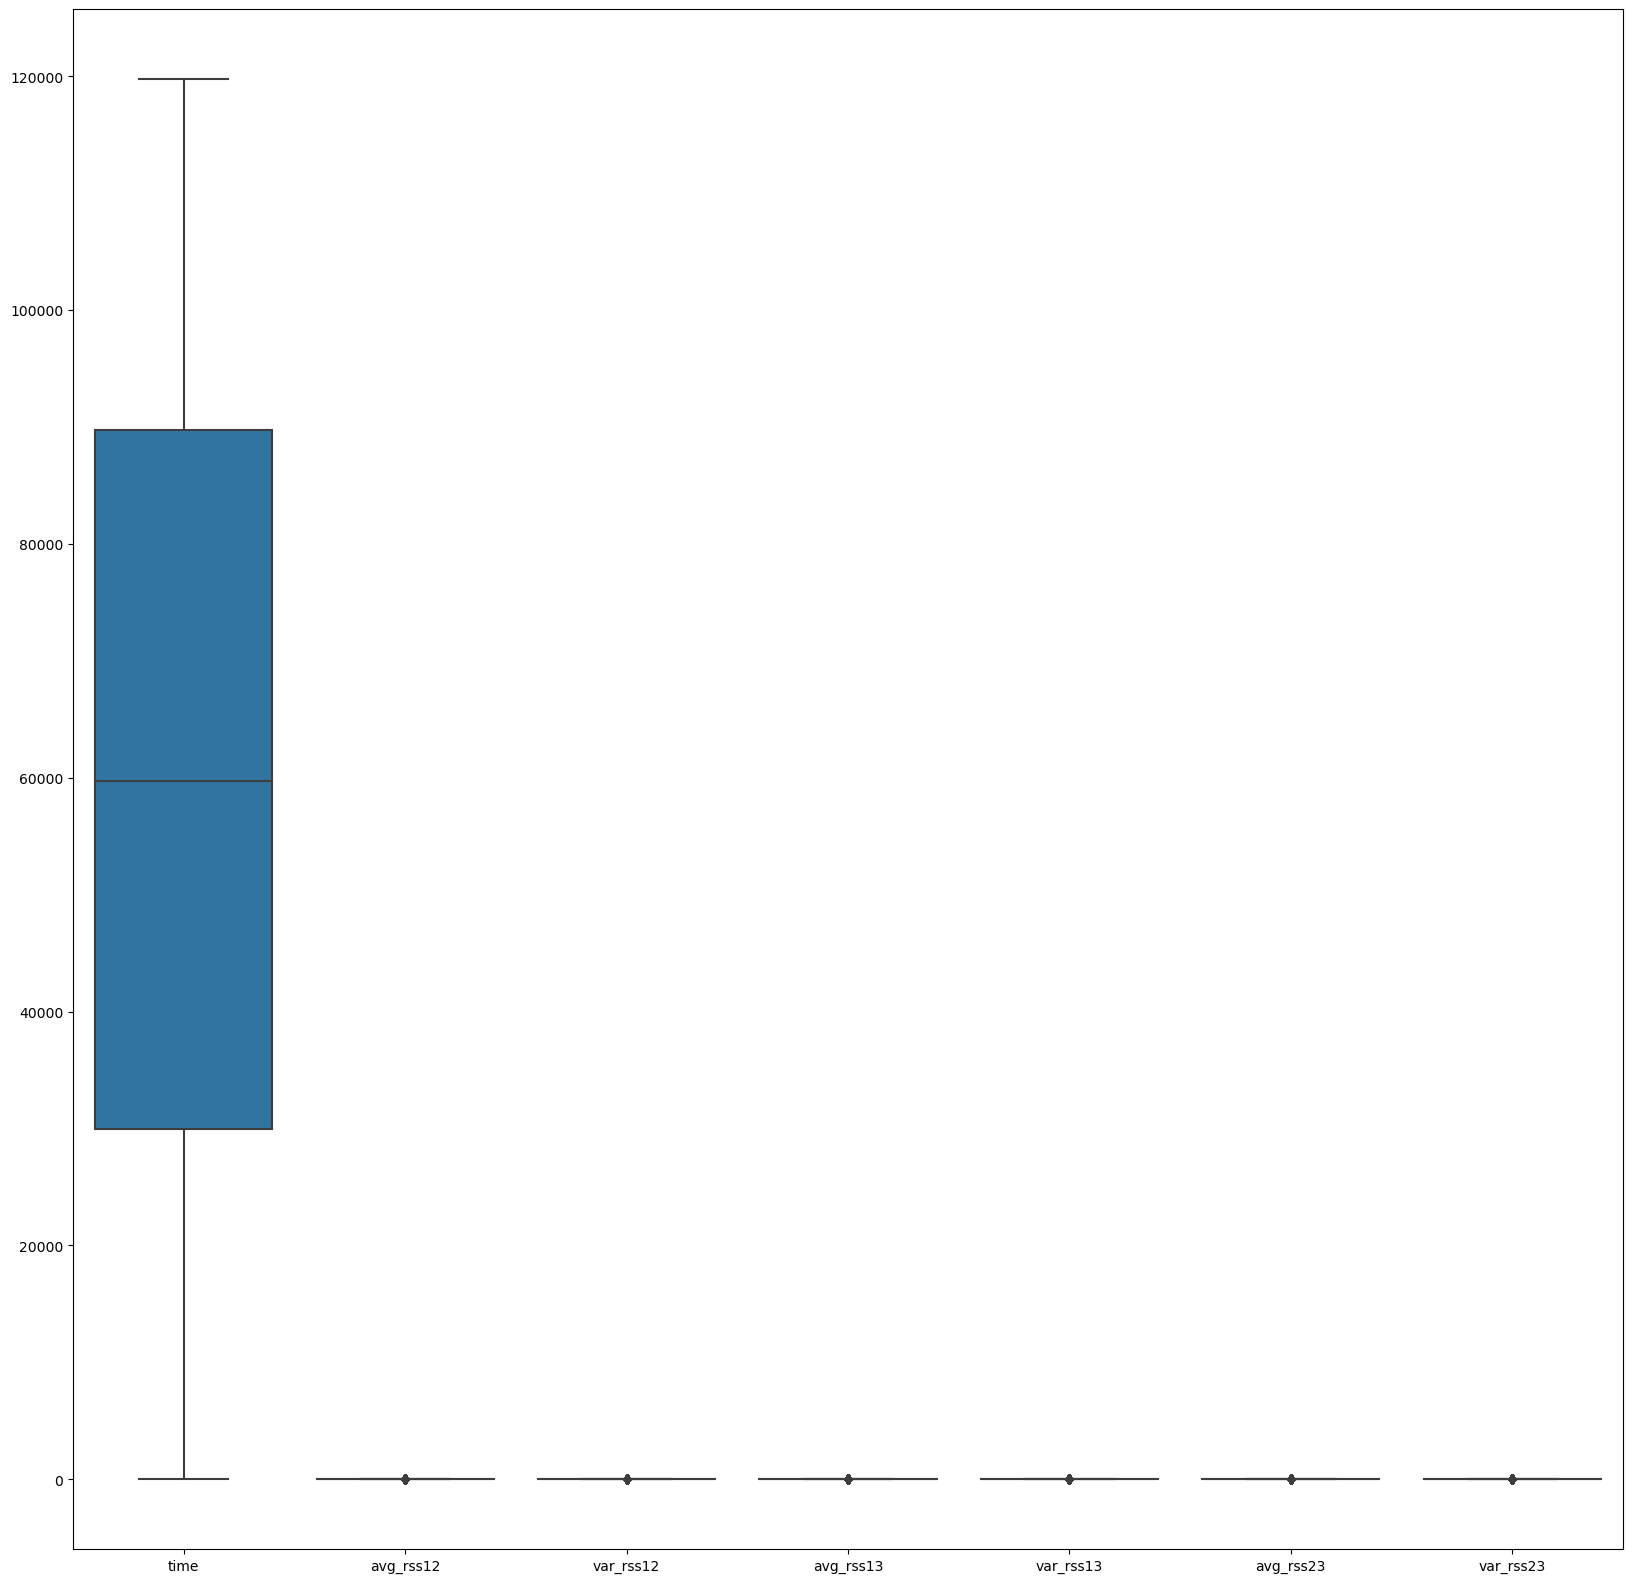

In [18]:
# Plotting each column and looking for abnormality

fig, ax=plt.subplots(figsize = (20,20))
sns.boxplot(data = df, ax = ax)

In [19]:
df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...,...
475,118750,31.50,1.66,12.50,3.20,14.25,4.44,walking
476,119000,27.33,1.25,11.33,0.94,20.00,4.00,walking
477,119250,37.80,7.68,14.20,2.48,17.25,0.83,walking
478,119500,33.75,1.30,15.75,5.21,16.50,2.69,walking


<AxesSubplot: >

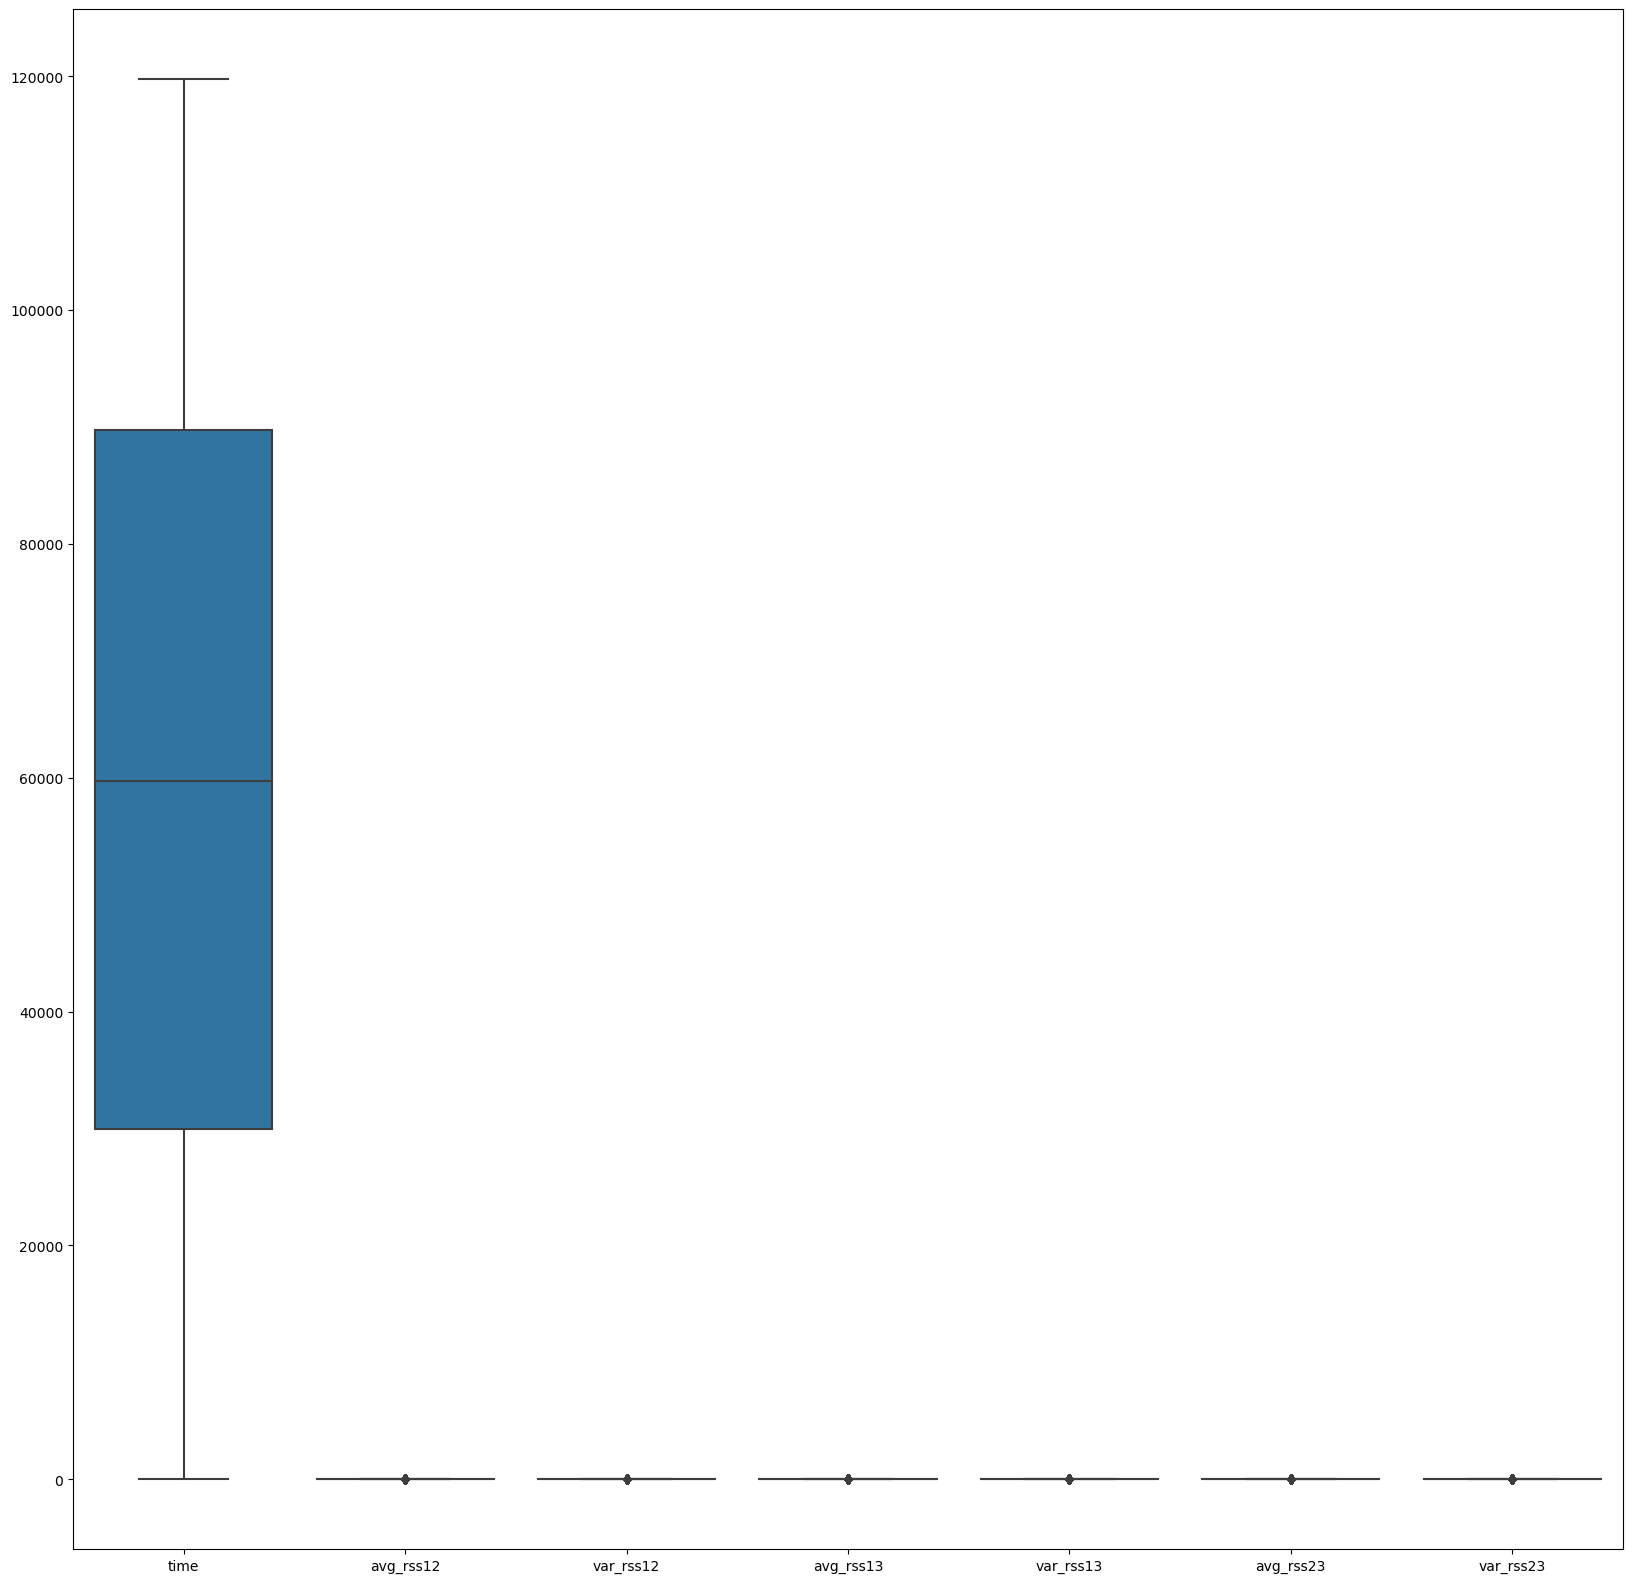

In [20]:
# Let's look again at our dataset

fig, ax=plt.subplots(figsize = (20,20))
sns.boxplot(data = df, ax = ax)

In [33]:
# Since there is an evidence of dissimilar scales, we will scale the features which are of numeric datatype

X = df.drop(columns = 'label')
y = df.label

In [34]:
# As a standard practice, let's standardize the numeric dataypes

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<AxesSubplot: >

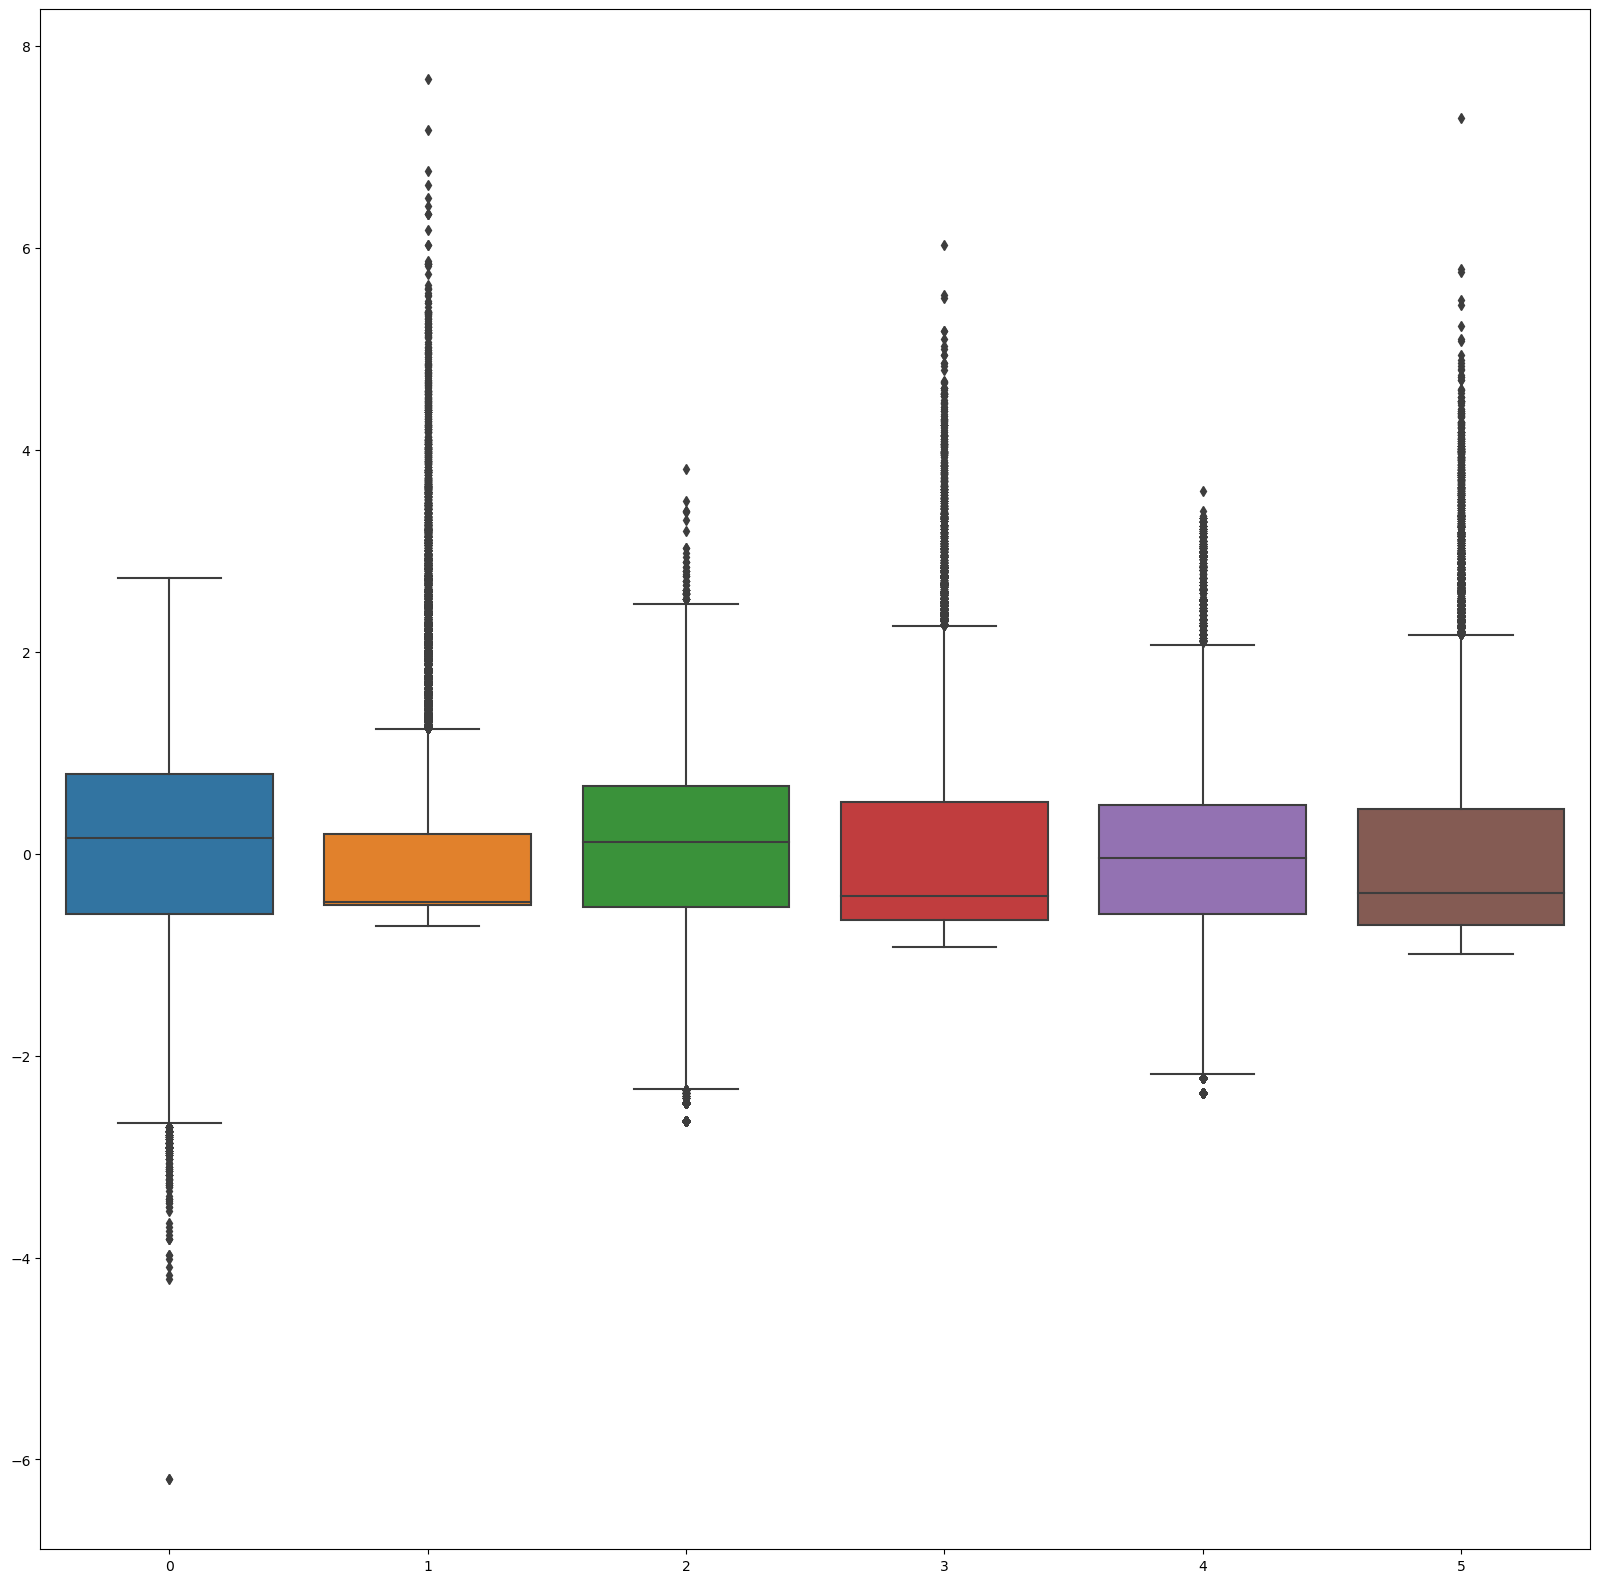

In [35]:
# All the features are almost of same scale now, we do have some outliers though.

fig, ax=plt.subplots(figsize = (20,20))
sns.boxplot(data = X_scaled, ax = ax)

## Selecting a sequence length of 10000 seconds

In [21]:
sequence_length = 60

In [38]:
# Saving the processed files to our local system

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.to_csv('processed_predictors.csv')
y.to_csv('labels.csv')

In [40]:
X_scaled_df

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0.036323,-0.507420,1.551777,-0.658797,2.620898,-0.201656
1,0.036323,-0.507420,1.597951,-0.920315,2.510088,-0.993051
2,0.036323,-0.507420,1.644125,-0.658797,2.510088,-0.993051
3,0.076021,-0.473364,1.597951,-0.488506,2.510088,-0.993051
4,0.076021,-0.473364,1.782646,-0.920315,2.510088,-0.993051
...,...,...,...,...,...,...
41752,-1.194322,0.090995,-0.341343,1.025865,-0.260180,1.709865
41753,-1.856489,-0.108477,-0.557436,-0.348625,0.589369,1.442008
41754,-0.193927,3.019820,-0.027362,0.587974,0.183063,-0.487776
41755,-0.837038,-0.084151,0.258914,2.248309,0.072252,0.644527
